# Pyscanpath practicle guide

`pyscanpath` is a framework to easily load and test few scanpath prediction models and to compare their result to a ground truth through some common metrics for scanpath evaluation.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pyscanpath.models.CLE import CLE
from pyscanpath.models.IttiKoch import IttiKoch
from pyscanpath.models.Deepgaze import Deepgaze
from pyscanpath.models.IORROI import IORROI
from pyscanpath.utils.metrics import printMetrics
from pyscanpath.utils.plotting import plotScanpath2


/Users/matteocastagna/Documents/GitHub/castagna-pyscanpath/pyscanpath/models/Iorroi/iorroi_utils.py:185: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536809/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  gaussian_kernel = nn.Parameter(torch.from_numpy(gaussian_kernel).float().unsqueeze(1))


Four models for scanpath prediction are available:
- __[Itti-Koch](https://github.com/DirkBWalther/SaliencyToolbox)__ (original in MATLAB, here partially rewritten in python)
- __[Constrained Levy Exploration (CLE)](https://github.com/phuselab/CLE)__
- __[DeepGazeIII](https://github.com/matthias-k/DeepGaze)__
- __[IOR-ROI Recurrent Mixture Density Network](https://github.com/sunwj/scanpath)__

In [2]:
img_path = 'sample/sample_image.jpg'
scanpath = np.load('sample/sample_scanpath.npy')
img = np.array( Image.open( img_path ) )

itti = IttiKoch()
cle = CLE()
deepgaze = Deepgaze()
iorroi = IORROI()

Using cache found in /Users/matteocastagna/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/matteocastagna/anaconda3/envs/natural_interaction/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matteocastagna/anaconda3/envs/natural_interaction/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Each model has its own module but they share the same instantiation and usage. `getScanPath()` is the function common to all the models used to generate the scanpath. It takes two arguments:
- the path of the image to which we want to predict the scanpath
- optionally, the numer of fixations to generate (default 10)

and returns the scanpath as a numpy array of shape (number of fixations $\times$ 2). The first coordinate is the vertical coordinate (y) the second one is the horizontal coordinate (x).

In [3]:
itti_scanpath = itti.getScanPath(img_path)
cle_scanpath = cle.getScanPath(img_path)
deepgaze_scanpath = deepgaze.getScanPath(img_path)
iorroi_scanpath = iorroi.getScanPath(img_path)

/Users/matteocastagna/Documents/GitHub/castagna-pyscanpath/pyscanpath/models/Deepgaze.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536809/work/torch/csrc/utils/tensor_new.cpp:278.)
  image_tensor = torch.tensor([self.img.transpose(2, 0, 1)]).to(self.device)


`getScanPath()` for Itti-Koch model and CLE takes additional arguments:
- Itti-Koch: saliency_type (default '01')
- CLE: saliency_type (default '98'), tauV (default 0.01), numSampleLevy (default 50), dt (default 0.1), T (default 25)

saliency_type is a string which define the type of saliency map to compute on which the scanpath will be predicted. saliency_type can be either '98' or '01'. '98' computes the saliency map accordingly to the original __[publication](https://arc.net/l/quote/sqtpelfk)__ of the Itti-Koch model. '01' computes the saliency accordingly to the implementation provided by D. B. Walther's __[Saliency Toolbox](https://github.com/DirkBWalther/SaliencyToolbox)__, derived from his __[PhD thesis](https://thesis.library.caltech.edu/895/)__. The main difference between the two is the way the normalization of the feature maps takes place. For those two models, once getScanPath is called, the respective saliency maps can be accessed as an instance attribute.

(-0.5, 1919.5, 1079.5, -0.5)

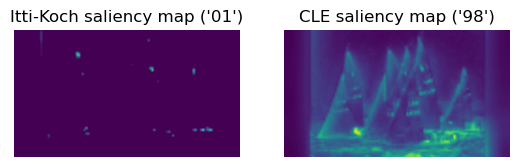

In [4]:
plt.subplot(1,2,1)
plt.imshow(itti.SM_fullSize)
plt.title('Itti-Koch saliency map (\'01\')')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cle.SM_fullSize)
plt.title('CLE saliency map (\'98\')')
plt.axis('off')

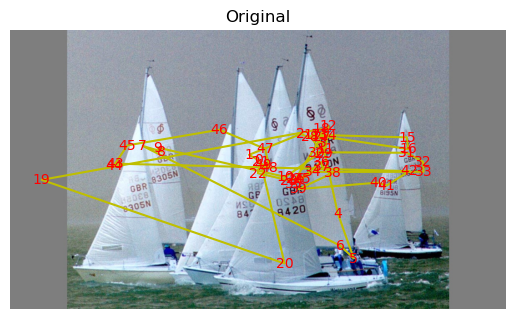

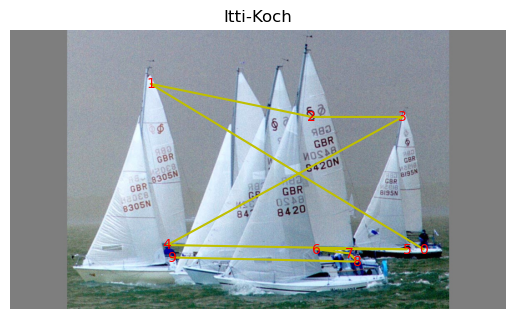

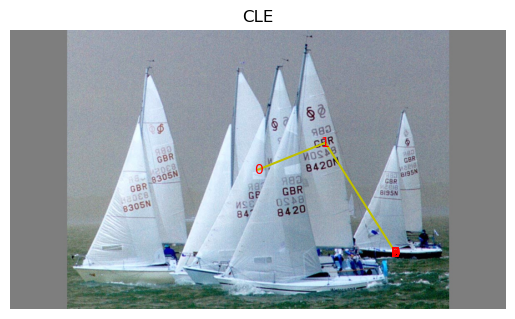

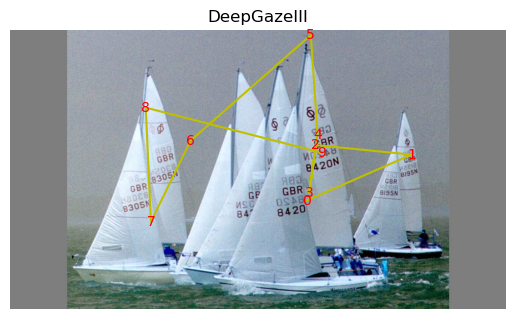

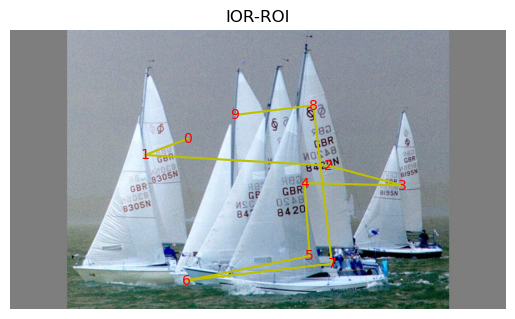

In [5]:
plotScanpath2(img = img,
             scanpath_list = [scanpath, itti_scanpath, cle_scanpath, deepgaze_scanpath, iorroi_scanpath],
             methods_list = ['Original', 'Itti-Koch', 'CLE', 'DeepGazeIII', 'IOR-ROI'])

The `metrics` module contains the functions to compute distances or similarity between scanpaths. Four metrics are implemented:
- Euclidean distance
- Mannan distance
- Edit distance
- Time delay embedding

Edit distance and time delay embedding implementations are taken from __[FixaTons](https://github.com/dariozanca/FixaTons/tree/master)__.
The four metrics can be computed together and printed in a table for all the scanpath predicted with the `printMetrics` function (default parameters for metrics which need additional arguments will be used).

In [6]:
printMetrics(img,
             scanpath,
             [itti_scanpath, cle_scanpath, deepgaze_scanpath, iorroi_scanpath],
             ['Itti-Koch', 'CLE', 'DeepGazeIII', 'IOR-ROI'])

Model          Euclidean     Mannan    Levenshtein       TDE
-----------  -----------  ---------  -------------  --------
Itti-Koch       0.614556  0.172189            0.96  0.865151
CLE             0.614556  0.0536168           0.96  0.865151
DeepGazeIII     0.614556  0.528904            0.92  0.865151
IOR-ROI         0.210459  0.541079            0.92  0.950995


# Using Pysaliency datasets

__[`pysaliency`](https://github.com/matthias-k/pysaliency/tree/dev)__ is a python library which aims at making, analyzing and modeling eye movement data. For the purpose of this tutorial, the MIT1003 dataset is used. `pysaliency` can download and import the dataset on it's own. In order to handle the format in which a scanpath is stored by `pysaliency`, so that it can work with `pyscanpath`, the functions to access the stimuli (images) and the fixations from the dataset are wrapped by the `getDatasetScanpath()` function contained in the `datasets` module:

`getDatasetScanpath()` takes as arguments:
- the name of the dataset to use, either 'MIT1003', 'CAT2000' or 'OSIE'
- the name of the folder which stores the dataset downloaded by `pysaliency`
- the index of the image in the dataset to analyze
- the index of the subject for which we want to analyze the scanpath

and returns:
- the path of the image we give the index
- the image we give the index
- the scanpath of the image and subject we give the indices


In [7]:
from pyscanpath.utils.datasets import *

dataset = 'MIT1003'
#dataset = 'CAT2000'
#dataset = 'OSIE'
data_location = 'pysaliency_datasets'
stimuli_index = 100
subject_index = 0

img_path, img, scanpath = getDatasetScanpath(dataset, data_location, stimuli_index, subject_index)


Using cache found in /Users/matteocastagna/.cache/torch/hub/pytorch_vision_v0.6.0


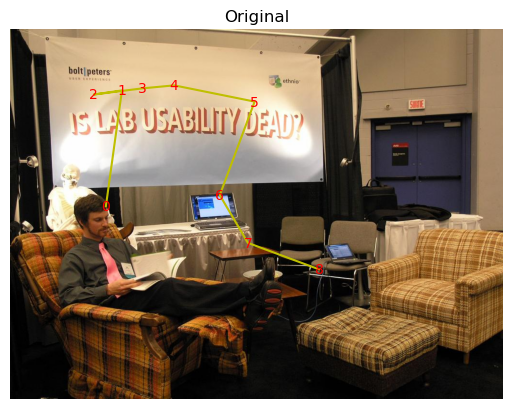

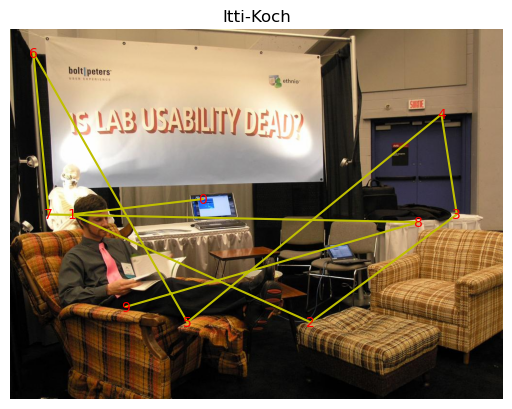

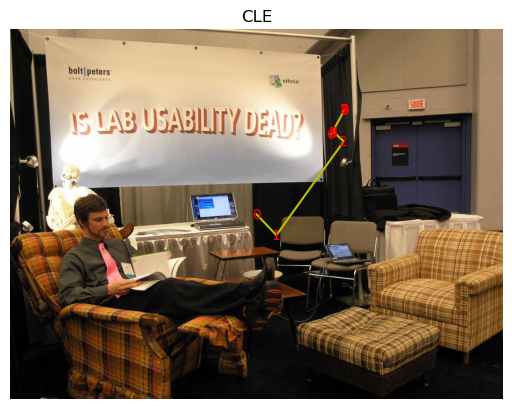

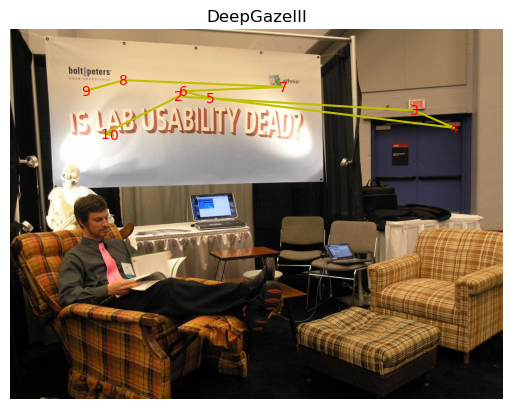

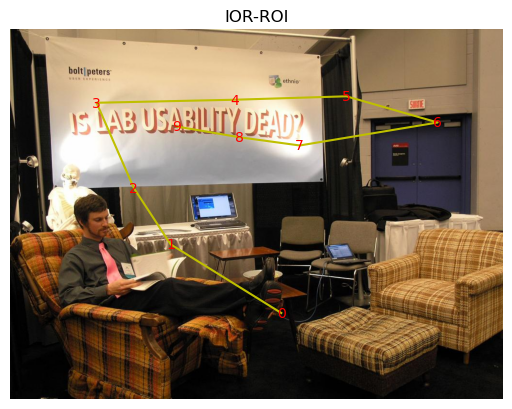

In [8]:
itti = IttiKoch()
cle = CLE()
deepgaze = Deepgaze()
iorroi = IORROI()

itti_scanpath = itti.getScanPath(img_path)
cle_scanpath = cle.getScanPath(img_path)
deepgaze_scanpath = deepgaze.getScanPath(img_path)
iorroi_scanpath = iorroi.getScanPath(img_path)

plotScanpath2(img = img,
             scanpath_list = [scanpath, itti_scanpath, cle_scanpath, deepgaze_scanpath, iorroi_scanpath],
             methods_list = ['Original', 'Itti-Koch', 'CLE', 'DeepGazeIII', 'IOR-ROI'])

In [9]:
printMetrics(img,
             scanpath,
             [itti_scanpath, cle_scanpath, deepgaze_scanpath, iorroi_scanpath],
             ['Itti-Koch', 'CLE', 'DeepGazeIII', 'IOR-ROI'])

Model          Euclidean    Mannan    Levenshtein       TDE
-----------  -----------  --------  -------------  --------
Itti-Koch       0.403938  0.333605            1    0.900761
CLE             0.403938  0.139242            1    0.900761
DeepGazeIII     0.403938  0.305604            1    0.900761
IOR-ROI         0.256324  0.322831            0.9  0.925515
